# 7장 시계열 데이터를 다뤄보자

### 작성 : [PinkWink](http://pinkwink.kr) 

## 7-1. Numpy의 polyfit으로 회귀(regression) 분석하기
* pip install pandas_datareader
* conda install -c conda-forge fbprophet

In [24]:
!pip install pandas_datareader


In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet
from datetime import datetime

In [5]:
path = "c:/Windows/Fonts/malgun.ttf"
import platform
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')    

plt.rcParams['axes.unicode_minus'] = False

In [6]:
pinkwink_web = pd.read_csv('../data/08. PinkWink Web Traffic.csv', 
                                          encoding='utf-8', thousands=',',
                                          names = ['date','hit'], index_col=0)
pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


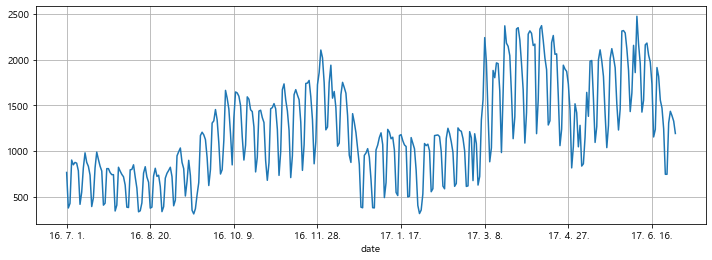

In [7]:
pinkwink_web['hit'].plot(figsize=(12,4), grid=True);

In [10]:
# 회귀를 하기위해
# 원소의 수 만큼 숫자를 만들어서 
# 타임이라는 가장 큰 숫자 중 -1은 가장 큰 수 
# 이것을 1000개 만든다
# linspace는 사이에 1000개의 점을 만들라는 것
# 범위 만들기 위해 사용한 것
time = np.arange(0,len(pinkwink_web))
traffic = pinkwink_web['hit'].values

fx = np.linspace(0, time[-1], 1000)

In [11]:
# 잘 보면 fx가 예측값인데
# y는 실제값이다. 
# 그래서 이것을 제곱을 하고 루트 씌운것이다
 # 근본적으로 우리가 했던 것과 똑같다
# 그래서 이 손실 에러라고 하는 것을 얼마만큼 손실률이 나올거냐 라는것
# 스스로 학습하는 것은 아니다
def error(f, x, y):
    return np.sqrt(np.mean((f(x)-y)**2))

In [12]:
# 이렇게 쓰면 알아서 기울기, 절편을 구해온다. np의 polyfit 사용한다면
# 이것으로 다시 다항식을 만든다
# 그래서 traffic의 원본 데이터를 다항식에 태우면
# 그것에 관한 직선이 그려진다.
# 그것을 에러로 측정한다
# 1차원 그래프인 경우
# 2차원  - 2차 방정식
# 3차원 - 3차 방정식

# 큰 차이 없다 
# 마지막은 15차원인데 굴곡 4개 그래프
# 그 곡선을 지원해서 그려진다
# 손실이 확 작아진다
# 이게 답은 아니다. 너무 점을 쫓게된다. 과대 적합. 너무 점에 근접하게 학습하면
# 최종 데이터가 왔을 때 예측하지 못한다
# 실제로는 직선이 더 좋다
# 비교하고자 이렇게 각각 값을 뽑은 것이다

fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1)

f2p = np.polyfit(time, traffic, 2)
f2 = np.poly1d(f2p)

f3p = np.polyfit(time, traffic, 3)
f3 = np.poly1d(f3p)

f15p = np.polyfit(time, traffic, 15)
f15 = np.poly1d(f15p)

print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

# 이렇게 하면 추세가 보인다 
# f1으로도 충분하다 라는 것을 보여주는 것



430.85973081109637
430.62841018946955
429.53280466762925
330.477730634393


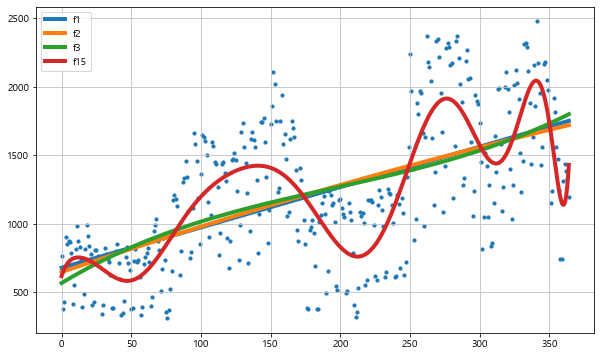

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(time, traffic, s=10)

plt.plot(fx, f1(fx), lw=4, label='f1')
plt.plot(fx, f2(fx), lw=4, label='f2')
plt.plot(fx, f3(fx), lw=4, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')

plt.grid(True, linestyle='-', color='0.75')

plt.legend(loc=2)
plt.show()

## 7-2. Prophet 모듈을 이용한 forecast 예측

In [16]:
df = pd.DataFrame({'ds':pinkwink_web.index, 'y':pinkwink_web['hit']})
df.reset_index(inplace=True)
df['ds'] =  pd.to_datetime(df['ds'], format="%y. %m. %d.")
del df['date']

m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(df);

In [17]:
future = m.make_future_dataframe(periods=60)
future.tail()

,ds
420,2017-08-25
421,2017-08-26
422,2017-08-27
423,2017-08-28
424,2017-08-29


In [18]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-08-25,905.968297,692.343153,1121.354120
421,2017-08-26,490.958897,287.141732,712.600138
422,2017-08-27,623.581075,398.281183,818.810842
423,2017-08-28,1176.248028,958.723585,1388.088852
424,2017-08-29,1212.236815,1011.916594,1428.317636


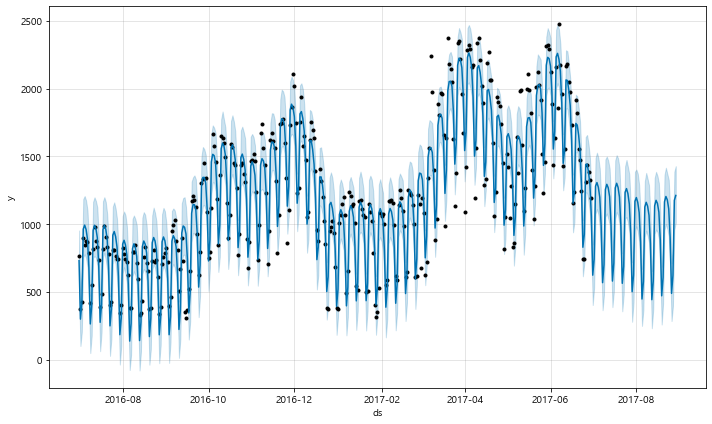

In [19]:
m.plot(forecast);

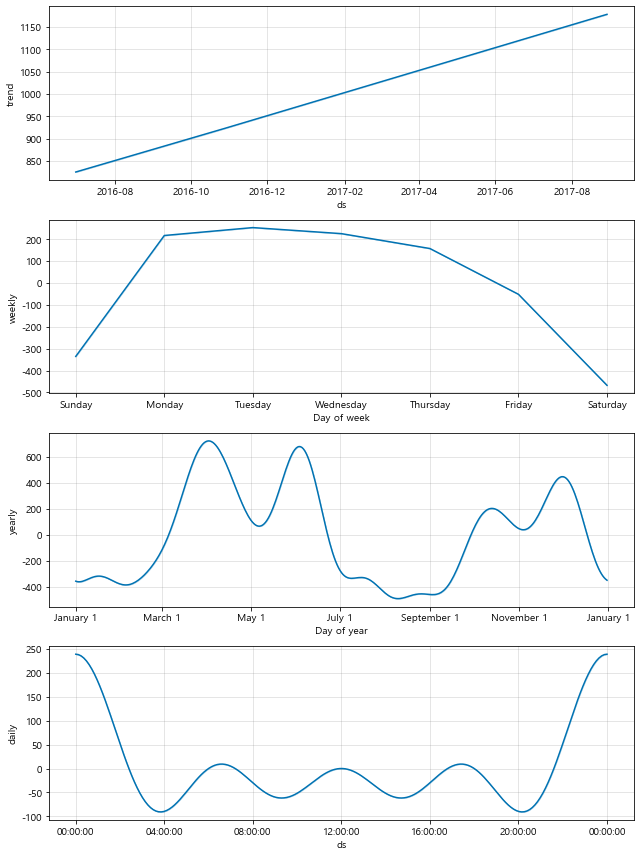

In [20]:
m.plot_components(forecast);

## 7-3. Seasonal 시계열 분석으로 주식 데이터 분석하기

In [28]:
!pip install yfinance

In [29]:
!pip install fix_yahoo_finance

  Using cached fix-yahoo-finance-0.1.37.tar.gz (6.3 kB)
  Created wheel for fix-yahoo-finance: filename=fix_yahoo_finance-0.1.37-py3-none-any.whl size=7062 sha256=e7c55b47e21bd5641a3396d106063886d5d7c65e448adc11d77be00be7bb53a2
  Stored in directory: c:\users\edu\appdata\local\pip\cache\wheels\1a\41\80\6cd5c10b88a3546cbe4cb412633ef2d12906510c403f723676
Successfully built fix-yahoo-finance


In [30]:
from pandas_datareader import data
import fix_yahoo_finance as yf
yf.pdr_override()

start_date = '1990-1-1' 
end_date = '2017-6-30' 
KIA = data.get_data_yahoo('000270.KS', start_date, end_date)
    
# KIA = web.DataReader('KRX:000270','google',start,end) # 구글용... 동작이 안됨
# KIA = web.DataReader('000270.KS','yahoo',start,end) # 구글용... 동작이 안됨
KIA.head()

C:\Users\edu\anaconda3\lib\site-packages\fix_yahoo_finance\__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



TypeError: download() missing 1 required positional argument: 'tickers'

In [22]:
KIA['Close'].plot(figsize=(12,6), grid=True);

NameError: name 'KIA' is not defined

In [20]:
KIA_trunc = KIA[:'2016-12-31']
KIA_trunc

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,7404.520020,7665.240234,7300.229980,7665.240234,5963.754395,636300
2000-01-05,7404.520020,7404.520020,7248.089844,7248.089844,5639.200684,686100
2000-01-06,7331.520020,7519.240234,6935.220215,6935.220215,5395.779297,379000
2000-01-07,6987.359863,7143.799805,6778.790039,6778.790039,5274.072754,701400
2000-01-10,6841.359863,7102.080078,6810.069824,7091.649902,5517.486816,1076700
2000-01-11,7143.799805,7717.390137,7143.799805,7717.390137,6004.329590,1127200
2000-01-12,7717.390137,8447.410156,7300.229980,7508.810059,5842.046875,1606600
2000-01-13,7696.529785,7696.529785,7195.939941,7195.939941,5598.626953,702700
2000-01-14,7195.939941,7508.810059,6987.359863,7508.810059,5842.046875,843900


In [21]:
df = pd.DataFrame({'ds':KIA_trunc.index, 'y':KIA_trunc['Close']})
df.reset_index(inplace=True)
del df['Date']
df.head()

,ds,y
0,2000-01-04,7665.240234
1,2000-01-05,7248.089844
2,2000-01-06,6935.220215
3,2000-01-07,6778.790039
4,2000-01-10,7091.649902


In [22]:
m = Prophet(daily_seasonality=True)
m.fit(df);

In [23]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
4578,2017-12-25
4579,2017-12-26
4580,2017-12-27
4581,2017-12-28
4582,2017-12-29


In [24]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4578,2017-12-25,35699.306886,27157.052528,43923.351486
4579,2017-12-26,35743.889629,26757.379710,44155.025684
4580,2017-12-27,35712.929531,27038.611107,43652.806439
4581,2017-12-28,35677.765597,26800.186968,43990.224264
4582,2017-12-29,35615.004272,26918.772596,44223.135097


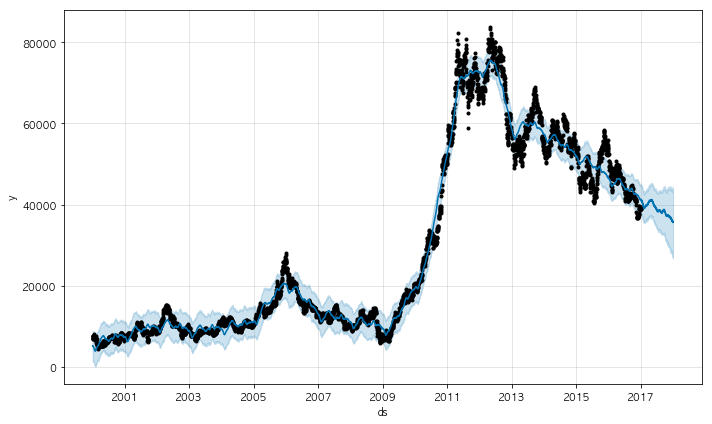

In [25]:
m.plot(forecast);

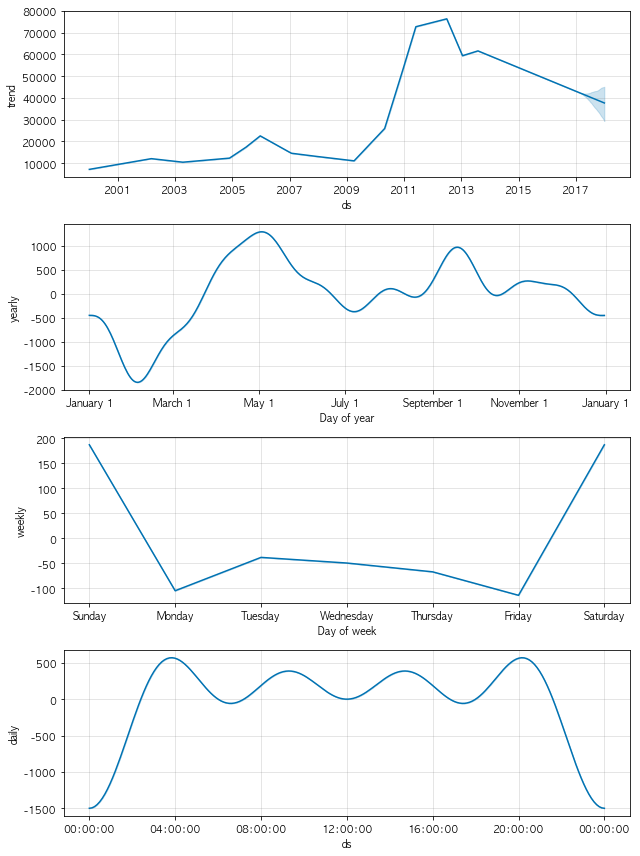

In [26]:
m.plot_components(forecast);

[*********************100%***********************]  1 of 1 downloaded


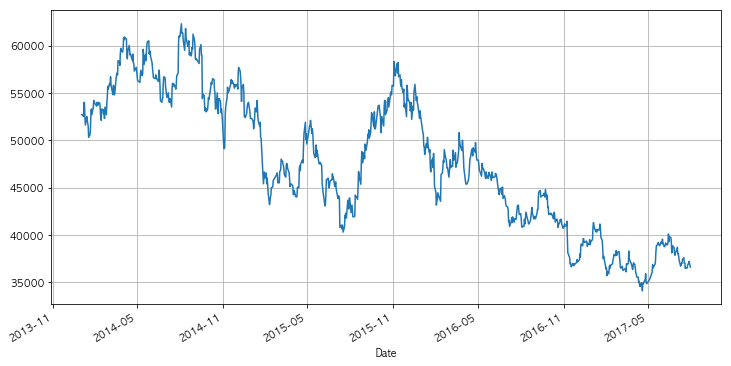

In [27]:
start_date = '2014-1-1' 
end_date = '2017-7-31' 
KIA = data.get_data_yahoo('000270.KS', start_date, end_date)
KIA['Close'].plot(figsize=(12,6), grid=True);

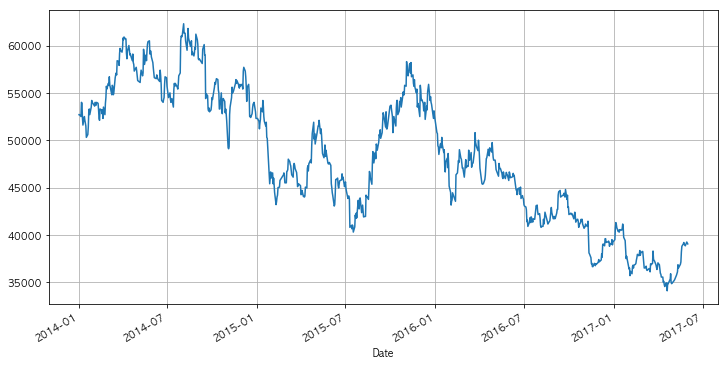

In [28]:
KIA_trunc = KIA[:'2017-05-31']
KIA_trunc['Close'].plot(figsize=(12,6), grid=True);

In [29]:
df = pd.DataFrame({'ds':KIA_trunc.index, 'y':KIA_trunc['Close']})
df.reset_index(inplace=True)
del df['Date']

In [30]:
m = Prophet(daily_seasonality=True)
m.fit(df);

In [31]:
future = m.make_future_dataframe(periods=61)
future.tail()

,ds
897,2017-07-27
898,2017-07-28
899,2017-07-29
900,2017-07-30
901,2017-07-31


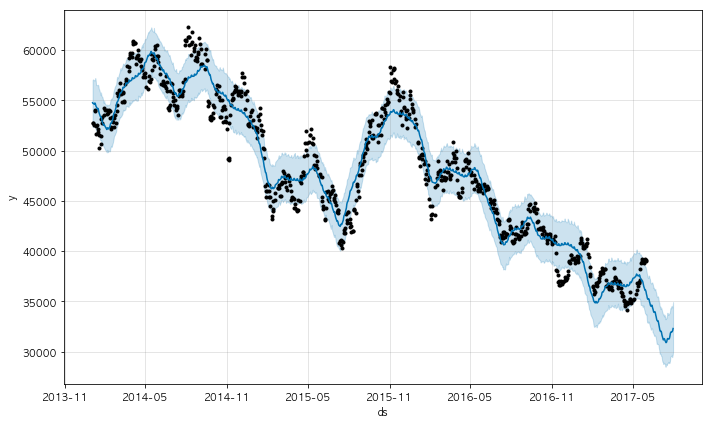

In [32]:
forecast = m.predict(future)
m.plot(forecast);

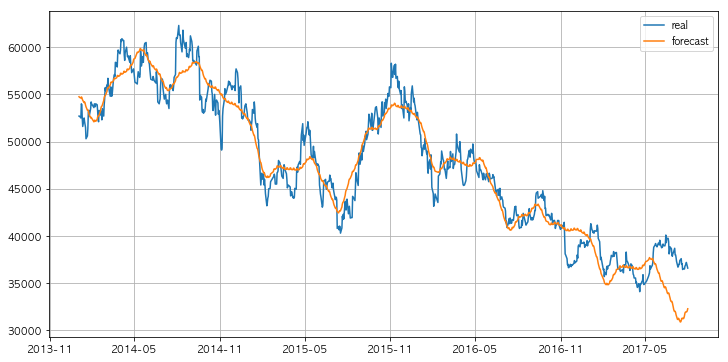

In [33]:
plt.figure(figsize=(12,6))
plt.plot(KIA.index, KIA['Close'], label='real')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()

## 7-4 Growth Model과 Holiday Forecast

In [34]:
df = pd.read_csv('../data/08. example_wp_R.csv')
df['y'] = np.log(df['y'])

In [35]:
df['cap'] = 8.5

In [36]:
m = Prophet(growth='logistic', daily_seasonality=True)
m.fit(df)

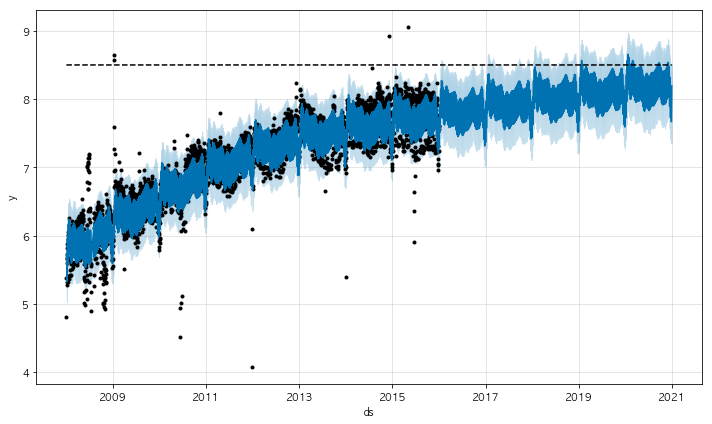

In [37]:
future = m.make_future_dataframe(periods=1826)
future['cap'] = 8.5
fcst = m.predict(future)
m.plot(fcst);

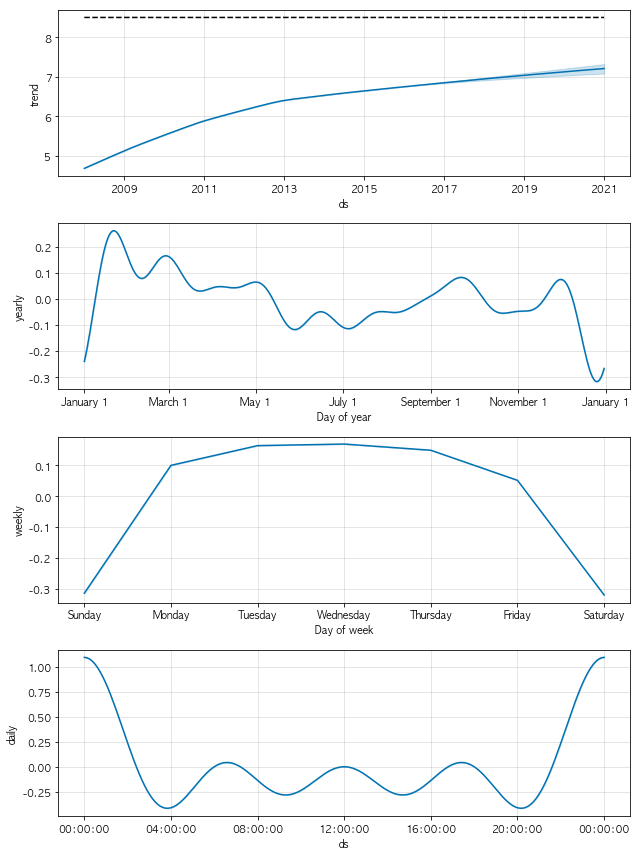

In [38]:
forecast = m.predict(future)
m.plot_components(forecast);

## holiday

In [39]:
df = pd.read_csv('../data/08. example_wp_peyton_manning.csv')
df['y'] = np.log(df['y'])
m = Prophet(daily_seasonality=True)
m.fit(df)
future = m.make_future_dataframe(periods=366)

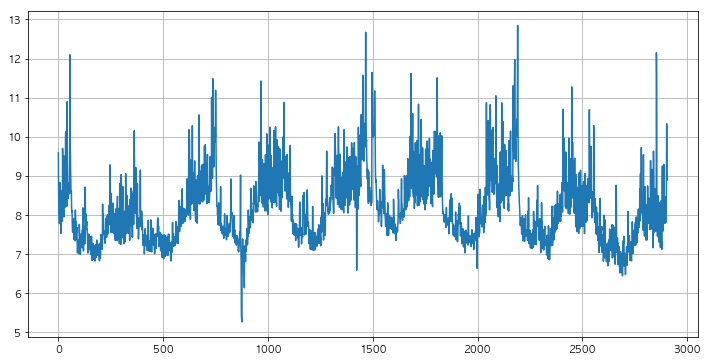

In [40]:
df.y.plot(figsize=(12,6), grid=True);

In [41]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [42]:
m = Prophet(holidays=holidays, daily_seasonality=True)
forecast = m.fit(df).predict(future)

In [43]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.225683,1.174862
2191,2014-02-03,1.901161,1.456941
2532,2015-01-11,1.225683,0.000000
2533,2015-01-12,1.901161,0.000000
2901,2016-01-17,1.225683,0.000000
2902,2016-01-18,1.901161,0.000000
2908,2016-01-24,1.225683,0.000000
2909,2016-01-25,1.901161,0.000000
2922,2016-02-07,1.225683,1.174862
2923,2016-02-08,1.901161,1.456941


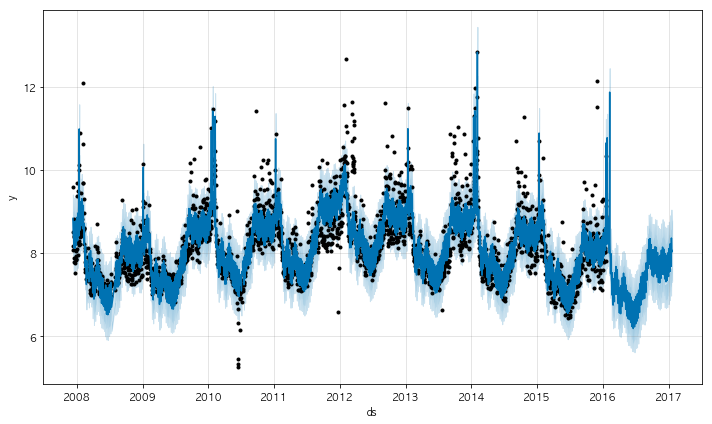

In [44]:
m.plot(forecast);

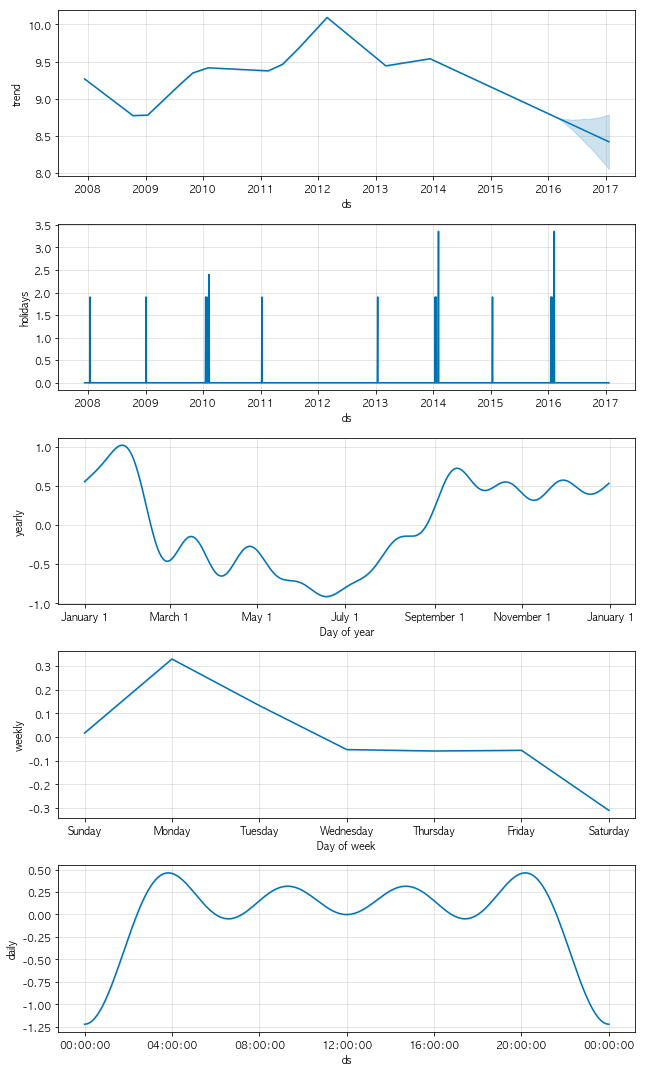

In [45]:
m.plot_components(forecast);